# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.0MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1cpwGHmONMCohLX-EQu9ubkB58ZoVc9pI' # The shareable link

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1cpwGHmONMCohLX-EQu9ubkB58ZoVc9pI


In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('opendata.csv')  
df3 = pd.read_csv('opendata.csv')

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [0]:
filtered_data=df3

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = df3

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 11)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 11)


5    31266
4     7213
1     4774
2     2818
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:18<00:00, 2516.70it/s]


In [0]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
def func(x):
  if x>3:
    return 1
  else:
    return 0

In [0]:

import numpy as np
from keras.models import Sequential
from keras.layers import Flatten,Activation,Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


Using TensorFlow backend.


In [0]:
x=preprocessed_reviews
y=final['Score'].apply(func)

In [0]:
from sklearn.model_selection import train_test_split
x1,xtest,y1,ytest=train_test_split(x,y,test_size=0.3,random_state=1)

In [0]:

xtrain,xcv,ytrain,ycv=train_test_split(x1,y1,test_size=0.2,random_state=1)

In [0]:
print(len(xtrain))
print(ytrain.shape)
print(len(xtest))
print(ytest.shape)
print(len(xcv))
print(ycv.shape)

25799
(25799,)
13822
(13822,)
6450
(6450,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()
xtrainonehotencoding=count_vect.fit_transform(xtrain)
xtestonehotencoding=count_vect.transform(xtest)
xcvonehotencoding=count_vect.transform(xcv)
print(xtrainonehotencoding.shape)
print(xtestonehotencoding.shape)
print(xcvonehotencoding.shape)

(25799, 29989)
(13822, 29989)
(6450, 29989)


In [0]:
print(count_vect.vocabulary_)

{'bitters': 2581, 'go': 11197, 'style': 25490, 'called': 3664, 'drinks': 8067, 'food': 10220, 'dishes': 7592, 'imperative': 12982, 'old': 18096, 'fashioned': 9543, 'manhattan': 15725, 'certainly': 4200, 'matter': 15958, 'taste': 26252, 'brand': 3062, 'considered': 5589, 'many': 15763, 'gold': 11229, 'standard': 25020, 'house': 12614, 'angostura': 1024, 'long': 15271, 'storied': 25307, 'history': 12388, 'shortage': 23683, 'bottles': 2945, 'years': 29745, 'ago': 510, 'put': 20901, 'product': 20497, 'short': 23682, 'supply': 25788, 'probably': 20441, 'worsened': 29569, 'hoarding': 12411, 'back': 1818, 'famous': 9487, 'oversized': 18594, 'labels': 14544, 'absent': 55, 'local': 15209, 'shelves': 23556, 'amazon': 830, 'reliable': 21726, 'source': 24579, 'bottle': 2941, 'size': 23946, 'last': 14675, 'lifetime': 14988, 'might': 16369, 'mention': 16194, 'brought': 3271, 'result': 22080, 'desire': 7099, 'add': 261, 'good': 11251, 'nuts': 17842, 'daily': 6494, 'diet': 7303, 'purchasing': 20833, '

In [0]:
myvocab=count_vect.vocabulary_

In [0]:
print(myvocab['bitters'])

2581


In [0]:
a={}
ben=[]
for i in count_vect.vocabulary_.values():
  ben.append(i)
print(np.argsort(ben))
k=0
for i in count_vect.vocabulary_.keys():
  a[i]=ben[k]
  k=k+1
print(a)

[11781 29208 18171 ...  6959 11144 25899]
{'bitters': 2581, 'go': 11197, 'style': 25490, 'called': 3664, 'drinks': 8067, 'food': 10220, 'dishes': 7592, 'imperative': 12982, 'old': 18096, 'fashioned': 9543, 'manhattan': 15725, 'certainly': 4200, 'matter': 15958, 'taste': 26252, 'brand': 3062, 'considered': 5589, 'many': 15763, 'gold': 11229, 'standard': 25020, 'house': 12614, 'angostura': 1024, 'long': 15271, 'storied': 25307, 'history': 12388, 'shortage': 23683, 'bottles': 2945, 'years': 29745, 'ago': 510, 'put': 20901, 'product': 20497, 'short': 23682, 'supply': 25788, 'probably': 20441, 'worsened': 29569, 'hoarding': 12411, 'back': 1818, 'famous': 9487, 'oversized': 18594, 'labels': 14544, 'absent': 55, 'local': 15209, 'shelves': 23556, 'amazon': 830, 'reliable': 21726, 'source': 24579, 'bottle': 2941, 'size': 23946, 'last': 14675, 'lifetime': 14988, 'might': 16369, 'mention': 16194, 'brought': 3271, 'result': 22080, 'desire': 7099, 'add': 261, 'good': 11251, 'nuts': 17842, 'daily': 

In [0]:

list1=[]
list2=[]
for x,y in a.items():
  list1.append(x)
  list2.append(y)

In [0]:
print(list1)

['bitters', 'go', 'style', 'called', 'drinks', 'food', 'dishes', 'imperative', 'old', 'fashioned', 'manhattan', 'certainly', 'matter', 'taste', 'brand', 'considered', 'many', 'gold', 'standard', 'house', 'angostura', 'long', 'storied', 'history', 'shortage', 'bottles', 'years', 'ago', 'put', 'product', 'short', 'supply', 'probably', 'worsened', 'hoarding', 'back', 'famous', 'oversized', 'labels', 'absent', 'local', 'shelves', 'amazon', 'reliable', 'source', 'bottle', 'size', 'last', 'lifetime', 'might', 'mention', 'brought', 'result', 'desire', 'add', 'good', 'nuts', 'daily', 'diet', 'purchasing', 'planter', 'energy', 'mix', 'stock', 'thought', 'would', 'give', 'try', 'fresh', 'delicious', 'whole', 'walnut', 'pieces', 'large', 'two', 'bites', 'least', 'seems', 'mostly', 'almonds', 'walnuts', 'fine', 'unlike', 'blue', 'diamond', 'smoked', 'not', 'overly', 'salty', 'plus', 'downside', 'little', 'sticky', 'paper', 'include', 'reseal', 'package', 'opening', 'work', 'well', 'ended', 'puttin

In [0]:
print(xtrain[:2])

['bitters go style called drinks food dishes imperative old fashioned manhattan bitters certainly matter taste brand considered many gold standard house angostura long storied history shortage bottles years ago put product short supply probably worsened hoarding angostura back famous oversized labels absent local shelves amazon reliable source bottle size last lifetime might mention', 'brought result desire add good nuts daily diet purchasing planter energy mix stock thought would give try fresh delicious whole nuts walnut pieces large two bites least mix seems mostly almonds walnuts fine good nuts unlike blue diamond smoked almonds nuts not overly salty plus downside little sticky paper include reseal package opening not work well ended putting nuts container keep fresh package would not stay closed opened']


In [0]:
xtrainfinal=[]
for sent in xtrain:
  preprocessedreviews1=[]
  sent1=list(sent.split(' '))
  for word in sent1:
    if word in myvocab.keys():
      preprocessedreviews1.append(myvocab[word])
  xtrainfinal.append(preprocessedreviews1)
    
 
    

In [0]:

print(len(xtrainfinal))

25799


In [0]:
xtestfinal=[]
for sent in xtest:
  preprocessedreviews1=[]
  sent1=list(sent.split(' '))
  for word in sent1:
    if word in myvocab.keys():
      preprocessedreviews1.append(myvocab[word])
  xtestfinal.append(preprocessedreviews1)
    
 
    

In [0]:
X_train=np.array(xtrainfinal)

In [0]:
X_test=np.array(xtestfinal)

In [0]:
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

In [0]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(xtrainfinal, maxlen=max_review_length)
X_test = sequence.pad_sequences(xtestfinal, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(25799, 600)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

##MODEL1

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,012,949
Trainable params: 1,012,949
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(X_train,ytrain,batch_size=128,epochs=20,validation_data=(X_test,ytest),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 25799 samples, validate on 13822 samples
Epoch 1/20
25799/25799 [==============================] - 452s 18ms/step - loss: 0.3269 - acc: 0.8704 - val_loss: 0.2200 - val_acc: 0.9140
Epoch 2/20
25799/25799 [==============================] - 453s 18ms/step - loss: 0.1653 - acc: 0.9363 - val_loss: 0.2201 - val_acc: 0.9162
Epoch 3/20
25799/25799 [==============================] - 451s 17ms/step - loss: 0.1136 - acc: 0.9591 - val_loss: 0.2467 - val_acc: 0.9020
Epoch 4/20
25799/25799 [==============================] - 443s 17ms/step - loss: 0.0868 - acc: 0.9698 - val_loss: 0.2769 - val_acc: 0.9028
Epoch 5/20
25799/25799 [==============================] - 444s 17ms/step - loss: 0.0638 - acc: 0.9786 - val_loss: 0.3414 - val_acc: 0.9075
Epoch 6/20
25799/25799 [==============================] - 446s 17ms/step - loss: 0.0479 - acc: 0.9848 - val_loss: 0.3395 - val_acc: 0.9033
Epoch 7/20
25799/25799 [==============================] - 444s 17ms/

In [0]:
scores = model.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 89.78%


In [0]:
def dynamicplot(x,validationy,testy,ax):
  ax.plot(x,validationy,label='validatiomn loss')
  ax.plot(x,testy,label='testloss')
  plt.xlabel('epoch')
  plt.ylabel('categroicalcrossentropy')
  plt.legend()
  plt.show()

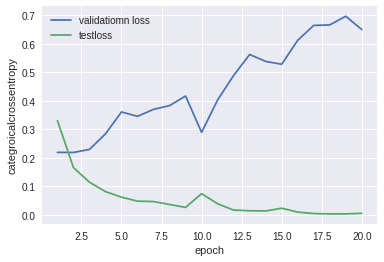

In [0]:
fig,ax=plt.subplots()
x=list(range(1,21))
validationy=history.history['val_loss']
testy=history.history['loss']
dynamicplot(x,validationy,testy,ax)

##MODEL2

In [0]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [0]:
history=model.fit(X_train,ytrain,batch_size=128,epochs=20,validation_data=(X_test,ytest),verbose=1)

Train on 25799 samples, validate on 13822 samples
Epoch 1/20
25799/25799 [==============================] - 417s 16ms/step - loss: 0.8127 - acc: 0.6488 - val_loss: 0.7851 - val_acc: 0.5618
Epoch 2/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.3805 - acc: 0.8503 - val_loss: 0.6557 - val_acc: 0.7409
Epoch 3/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.2324 - acc: 0.9174 - val_loss: 0.3492 - val_acc: 0.8777
Epoch 4/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.1603 - acc: 0.9433 - val_loss: 0.3331 - val_acc: 0.8992
Epoch 5/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.1198 - acc: 0.9584 - val_loss: 0.5055 - val_acc: 0.8748
Epoch 6/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.1024 - acc: 0.9637 - val_loss: 0.6252 - val_acc: 0.8056
Epoch 7/20
25799/25799 [==============================] - 417s 16ms/step - loss: 0.0722 - acc: 0.9765 - val_loss: 0.

In [0]:
scores = model.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 89.91%


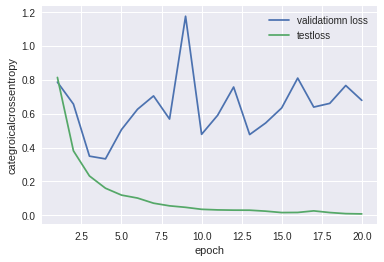

In [0]:
fig,ax=plt.subplots()
x=list(range(1,21))
validationy=history.history['val_loss']
testy=history.history['loss']
dynamicplot(x,validationy,testy,ax)

##MODEL3

In [0]:
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
model1.add(LSTM(1000,return_sequences=True))
model1.add(BatchNormalization())
model1.add(LSTM(100))
model1.add(BatchNormalization())
model1.add(Dropout(0.8))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,012,949
Trainable params: 1,012,949
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model.fit(X_train,ytrain,batch_size=128,epochs=20,validation_data=(X_test,ytest),verbose=1)

Train on 25799 samples, validate on 13822 samples
Epoch 1/20
25799/25799 [==============================] - 414s 16ms/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.7049 - val_acc: 0.8935
Epoch 2/20
25799/25799 [==============================] - 412s 16ms/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.6454 - val_acc: 0.8951
Epoch 3/20
25799/25799 [==============================] - 411s 16ms/step - loss: 0.0066 - acc: 0.9977 - val_loss: 0.7610 - val_acc: 0.8889
Epoch 4/20
25799/25799 [==============================] - 412s 16ms/step - loss: 0.0079 - acc: 0.9976 - val_loss: 0.7040 - val_acc: 0.8933
Epoch 5/20
25799/25799 [==============================] - 411s 16ms/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.7204 - val_acc: 0.8967
Epoch 6/20
25799/25799 [==============================] - 411s 16ms/step - loss: 0.0108 - acc: 0.9971 - val_loss: 0.6732 - val_acc: 0.8927
Epoch 7/20
25799/25799 [==============================] - 410s 16ms/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.

In [0]:
scores = model.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 89.06%


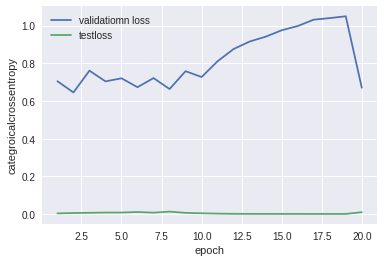

In [0]:
fig,ax=plt.subplots()
x=list(range(1,21))
validationy=history.history['val_loss']
testy=history.history['loss']
dynamicplot(x,validationy,testy,ax)

##MODEL4

In [0]:
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras.layers import LSTM,Dense

In [0]:
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(1000,return_sequences=True))
model2.add(BatchNormalization())
model2.add(LSTM(100,return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dropout(0.8))
model2.add(LSTM(10))
model2.add(BatchNormalization())
model2.add(Dropout(0.8))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 1000)         4132000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 1000)         4000      
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          440400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 600, 100)          400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 100)          0         
___________________________

In [0]:
history=model2.fit(X_train,ytrain,batch_size=128,epochs=4,validation_data=(X_test,ytest))

Train on 25799 samples, validate on 13822 samples
Epoch 1/3
25799/25799 [==============================] - 12762s 495ms/step - loss: 0.8626 - acc: 0.6283 - val_loss: 0.6819 - val_acc: 0.6679
Epoch 2/3
25799/25799 [==============================] - 12706s 492ms/step - loss: 0.5706 - acc: 0.7977 - val_loss: 0.8887 - val_acc: 0.6974
Epoch 3/3
25799/25799 [==============================] - 12656s 491ms/step - loss: 0.5251 - acc: 0.8255 - val_loss: 2.6009 - val_acc: 0.8369


In [0]:
scores = model2.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 83.69%


##MODEL5

In [0]:
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(100))
model2.add(Dense(1, activation='softmax'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,012,949
Trainable params: 1,012,949
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history=model2.fit(X_train,ytrain,batch_size=128,epochs=10,validation_data=(X_test,ytest))

Train on 25799 samples, validate on 13822 samples
Epoch 1/10
25799/25799 [==============================] - 430s 17ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 2/10
25799/25799 [==============================] - 426s 17ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 3/10
25799/25799 [==============================] - 426s 17ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 4/10
25799/25799 [==============================] - 425s 16ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 5/10
25799/25799 [==============================] - 425s 16ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 6/10
25799/25799 [==============================] - 426s 17ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.6021 - val_acc: 0.8368
Epoch 7/10
25799/25799 [==============================] - 427s 17ms/step - loss: 2.6287 - acc: 0.8351 - val_loss: 2.

In [0]:
scores = model2.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 83.68%


##MODEL 6


In [0]:
# create the model
embedding_vecor_length = 32
modelx = Sequential()
modelx.add(Embedding(29989, embedding_vecor_length, input_length=max_review_length))
modelx.add(LSTM(200))
modelx.add(Dense(1, activation='sigmoid'))
modelx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelx.summary())
history=modelx.fit(X_train,ytrain,batch_size=128,epochs=20,validation_data=(X_test,ytest))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           959648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,146,249
Trainable params: 1,146,249
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 25799 samples, validate on 13822 samples
Epoch 1/20
25799/25799 [==============================] - 883s 34ms/step - loss: 0.3362 - acc: 0.8682 - val_loss: 0.2216 - val_acc: 0.9148
Epoch 2/20
25799/25799 [==============================] - 867s 34ms/step - loss: 0

In [0]:
scores = model.evaluate(X_test, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 89.06%


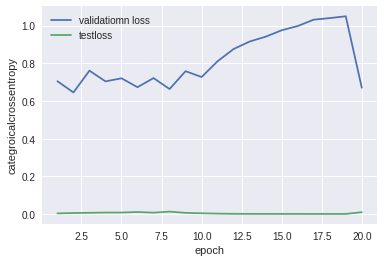

In [0]:
fig,ax=plt.subplots()
x=list(range(1,21))
validationy=history.history['val_loss']
testy=history.history['loss']
dynamicplot(x,validationy,testy,ax)

In [6]:
import pandas as pd

data = [[1,'(100,1)',20,90,'no','no'],[1,'(100,100,1)',20,90,'yes','yes'],[2,'(100,100,1)',20,89,'yes','yes'],[3,'(1000,100,10,1)',3,84,'yes','yes'],[1,'(100,1)',20,84,'no','no'],[1,'(200,1)',20,84,'no','no']]
pd.DataFrame(data, columns=["number of LSTM layers",'configuration','epochs','testsccuracy','using_dropouts','using_batch_normalisation'],index=['1','2','3','4','5','6'])


,number of LSTM layers,configuration,epochs,testsccuracy,using_dropouts,using_batch_normalisation
1,1,"(100,1)",20,90,no,no
2,1,"(100,100,1)",20,90,yes,yes
3,2,"(100,100,1)",20,89,yes,yes
4,3,"(1000,100,10,1)",3,84,yes,yes
5,1,"(100,1)",20,84,no,no
6,1,"(200,1)",20,84,no,no


##CONCLUSIONS DOCUMENTATION AND KEYTAKEAWAYS
### WE PERFORMING THE EXPLORATORY DATA ANALYSIS AND FEATURE EXTRACTION WE SPLIT THE DATA INTO TRAIN TEST AND CROSS VALIDATAION. WE HAVE DONE FEATURE BEFORE DEPLOYING INTO MODELS WITH ONEHOTENCODING. DEPLOYING INTO MODELS WE USED DROPOUT LAYERS AND BATCHNORMALISATION. WE USED DROPOUT TO PREVENT THE OVERFITTING OF MODEL. UDSING THE DROPOUT LAYER WILL TURNOFF THE CELLS WHILE BACKPROPOGATION. WE USE THE BATCHNORMALISATION BECAUSE DUE TO ACTIVATION FUNCTION THE INPUTS LOOSE THEIR ORIGINAL BEHAVIOR.
### WE HAVE RESTRICTED THE MAXIMUM LENGTH AND PADDED THE DATA WHEN THE NUMERS OF FEATURES ENCODED ARE LESS THAN 600.
### CREATING THE MODEL WE ARE UISNG THE LSTM LAYER WITH SIGMOID AS THE ACTIVATION FUNCTION AT THE DENSE LAYER. 
### THE DENSE LAYER CONSISTSOF SINGLE OUTPUT WHICH CAN BE 1 OR O. THIS WAY WE PERFORM THE BINARY CLSSIFICATION TASK.
### WE PLOT THE VAIDATION LOSS AND TEST LOSS TO VISUALISE HOW THE MODELS ARE CONVERGING.
### IN MODEL1 WE USED THE SINGLE LSTM LAYER WE ARE ABLE TO ACHIEVE THE ACCURACY OF 90 PERCENT WITH NO DROPOUTS AND BATCH NORMALISATION PERFORMED.
###USING THE 1 LSTM LAYERS WITH BATCH NORMALIATION AND DROPOUT WE ARE ABLE ACHIEVE ACCURACY OF 90 PERCENT. 
###IN THE MODELS WE ARE UISNG THE NUMBER OF EPOCHS AS 20 WITH 2 LSTM LAYERS WITH BOTH DOPOUT AND BATCH NORMALISATION ACHIVED THE ACCURACY OF 89 PERCENT.
### WITH 3 LSTM LAYERS TAKES THE TRAINING TIME COMPLEXITY IS VERY HIGH WITH 3 EPOCHS WE ARE ABLE TO ACHIEVE ACCURACY OF 84 PERDCENT 
### THE KEY TAKE AWAY USING THE LESS NUMBER OF EPOCHS IN THE MODEL5 WITH SINGLE LSTM LAYER WE ARE ABLE TO ACHIEVE 84 PERCENT WITH NO DROPOUTS AND BATCHNORMALISATION AND NORO DROPOUTS.
## THE KEYTAKE AWAY IS WITH OUT THE BATCHNORMALISATION AND DROPOUT A THE MODEL MAY OVER FIT AND THE NO NORMALISATO AN LEAD TO LESS ACCURACY.
### ANOTHER KEY TAKE AWAY SAME AS THE PREVIOUS CONFIGURATION INCREASING THE NUMBER OF CELLS IN HIDDENLAYER WILL INREASE THE PERFORMANCE.